# Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the Decision Tree Classifier

In [3]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def _gini_index(self, groups, classes):
        """Calculate the Gini index for a split."""
        n_samples = sum(len(group) for group in groups)
        gini = 0.0
        for group in groups:
            size = len(group)
            if size == 0:
                continue
            score = 0.0
            for class_val in classes:
                proportion = (group[:, -1] == class_val).sum() / size
                score += proportion ** 2
            gini += (1 - score) * (size / n_samples)
        return gini

    def _split(self, index, value, dataset):
        """Split a dataset into left and right groups based on a feature and value."""
        left, right = [], []
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return np.array(left), np.array(right)

    def _best_split(self, dataset):
        """Find the best feature and value to split on."""
        class_values = np.unique(dataset[:, -1])
        best_index, best_value, best_score, best_groups = None, None, float("inf"), None
        for index in range(dataset.shape[1] - 1):  # Exclude the label column
            for row in dataset:
                groups = self._split(index, row[index], dataset)
                if any(len(group) == 0 for group in groups):  # Skip empty splits
                    continue
                gini = self._gini_index(groups, class_values)
                if gini < best_score:
                    best_index, best_value, best_score, best_groups = index, row[index], gini, groups
        return {'index': best_index, 'value': best_value, 'groups': best_groups}

    def _to_terminal(self, group):
        """Create a terminal node."""
        outcomes = group[:, -1]
        return np.bincount(outcomes.astype(int)).argmax()

    def _split_node(self, node, depth):
        """Create child splits for a node or make it a terminal."""
        left, right = node['groups']
        del node['groups']

        # Check for no split
        if not len(left) or not len(right):
            node['left'] = node['right'] = self._to_terminal(np.vstack((left, right)))
            return

        # Check for maximum depth
        if self.max_depth and depth >= self.max_depth:
            node['left'], node['right'] = self._to_terminal(left), self._to_terminal(right)
            return

        # Process left child
        if len(left) <= self.min_samples_split:
            node['left'] = self._to_terminal(left)
        else:
            node['left'] = self._best_split(left)
            self._split_node(node['left'], depth + 1)

        # Process right child
        if len(right) <= self.min_samples_split:
            node['right'] = self._to_terminal(right)
        else:
            node['right'] = self._best_split(right)
            self._split_node(node['right'], depth + 1)

    def fit(self, X, y):
        """Fit the Decision Tree to the dataset."""
        dataset = np.hstack((X, y.reshape(-1, 1)))
        self.tree = self._best_split(dataset)
        self._split_node(self.tree, 1)

    def _predict(self, node, row):
        """Make a prediction for a single sample."""
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self._predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self._predict(node['right'], row)
            else:
                return node['right']

    def predict(self, X):
        """Predict class labels for samples in X."""
        return np.array([self._predict(self.tree, row) for row in X])

# Generate Synthetic Dataset

In [5]:
X, y = make_classification(
    n_samples=300, 
    n_features=2, 
    n_classes=3, 
    n_clusters_per_class=1, 
    n_redundant=0, 
    n_informative=2, 
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Decision Tree Model

In [6]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=5)
tree.fit(X_train, y_train)

# Predict and Evaluate

In [7]:
y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.94


# Visualize Decision Boundaries

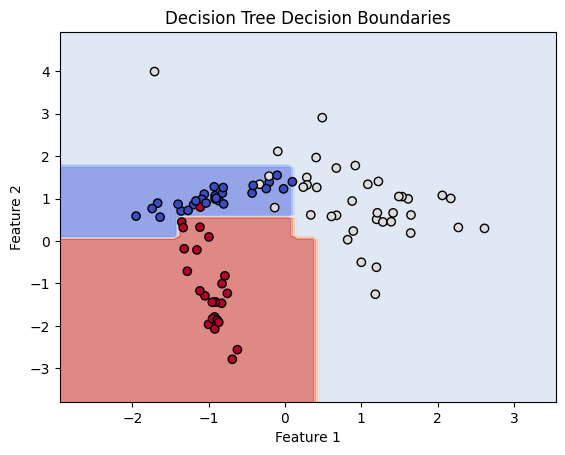

In [8]:
def plot_decision_boundaries(X, y, tree):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid = np.c_[xx.ravel(), yy.ravel()]
    predictions = tree.predict(grid)
    plt.contourf(xx, yy, predictions.reshape(xx.shape), alpha=0.6, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.title("Decision Tree Decision Boundaries")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_decision_boundaries(X_test, y_test, tree)